# a

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_CIR_paths_vectorized(a, b, sigma, r0, T=5.0, N=2000, M=10000, seed=42):
    np.random.seed(seed)
    dt = T / N
    times = np.linspace(0, T, N+1)
    r_paths = np.zeros((M, N+1))
    r_paths[:, 0] = r0
    epsilons = np.random.normal(0.0, 1.0, (M, N))
    for i in range(1, N+1):
        r_prev = np.maximum(r_paths[:, i-1], 0.0)
        r_paths[:, i] = (
            r_paths[:, i-1]
            + a * (b - r_paths[:, i-1]) * dt
            + sigma * np.sqrt(r_prev) * epsilons[:, i-1] * np.sqrt(dt)
        )
    return times, r_paths

def compute_discount_factors(r_paths, dt):
    return np.cumsum(r_paths[:, :-1], axis=1) * dt

def zero_coupon_bond_price_from_partial_sums(partial_sums, idx):
    integrals = partial_sums[:, idx]
    return np.mean(np.exp(-integrals))

def zero_coupon_bond_price_for_tenors(r_paths, times, tenors):
    dt = times[1] - times[0]
    partial_sums = compute_discount_factors(r_paths, dt)
    prices = []
    for tnr in tenors:
        idx = np.searchsorted(times, tnr)
        if idx >= partial_sums.shape[1]:
            idx = partial_sums.shape[1] - 1
        prices.append(zero_coupon_bond_price_from_partial_sums(partial_sums, idx) * 100)
    return np.array(prices)

model price: [99.56603249 98.71615321 97.4702155  95.06528337]


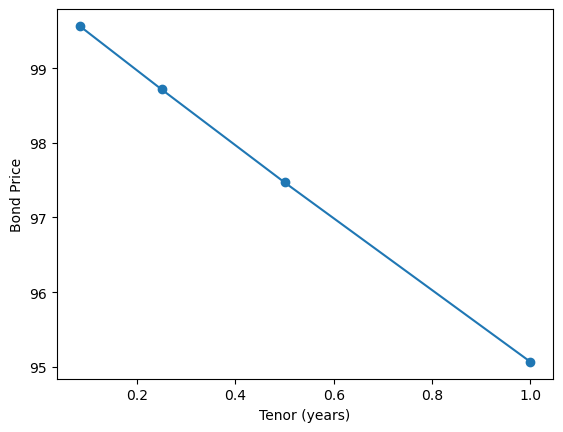

In [8]:
T, N, M = 5.0, 20000, 5000

a, b, sigma= 0.2, 0.04, 0.12
r0 = 0.052

times, r_paths = simulate_CIR_paths_vectorized(a, b, sigma, r0, T, N, M)

tenors = [1/12, 3/12, 6/12, 1.0]
prices = zero_coupon_bond_price_for_tenors(r_paths, times, tenors)
print(f'model price: {prices}')

plt.plot(tenors, prices, marker='o')
plt.xlabel("Tenor (years)")
plt.ylabel("Bond Price")
plt.show()

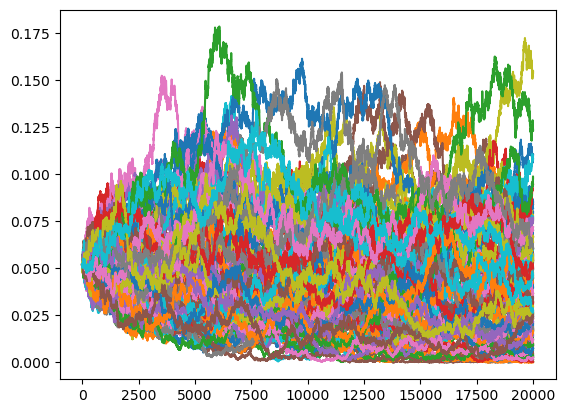

In [9]:
plt.plot(r_paths[:100,:].T)
plt.show()

# b

Calibrated a=0.32317, b=0.00518, sigma=0.13877


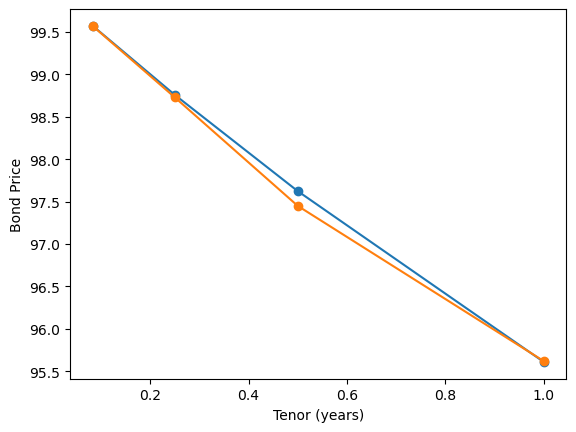

[99.5725678  98.75937801 97.62396702 95.61016421]


In [11]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds

def calibration_error(params, market_tenors, market_prices, r0, T, N, M, seed=42):
    a, b, sigma = params

    # if 2 * a * b < sigma**2:
    #     return np.inf
    
    times, r_paths = simulate_CIR_paths_vectorized(a, b, sigma, r0, T, N, M, seed=seed)
    model_prices = zero_coupon_bond_price_for_tenors(r_paths, times, market_tenors)
    err = np.mean((model_prices - market_prices)**2)

    return err

def calibration(market_tenors, market_prices, r0):
    T, N, M = 2.0, 10000, 2000
    x0 = np.array([0.2, 0.04, 0.12])
    
    bounds = Bounds(
        lb=[1e-8, 1e-8, 1e-8],
        ub=[np.inf, np.inf, np.inf]
    )

    def objective(params):
        return calibration_error(
            params, 
            market_tenors, 
            market_prices, 
            r0=r0, 
            T=T, 
            N=N, 
            M=M, 
            seed=42
        )

    result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)

    return result

if __name__ == "__main__":
    market_tenors = np.array([1/12, 3/12, 6/12, 1.0])
    market_prices = np.array([99.57, 98.73, 97.45, 95.62])
    r0 = 0.052

    res = calibration(market_tenors, market_prices, r0)
    if res.success:
        a_calib, b_calib, sigma_calib = res.x
        print(f"Calibrated a={a_calib:.5f}, b={b_calib:.5f}, sigma={sigma_calib:.5f}")
    else:
        print("Calibration failed:", res.message)

    T, N, M = 2.0, 10000, 5000
    times, r_paths = simulate_CIR_paths_vectorized(a_calib, b_calib, sigma_calib, r0, T, N, M)
    tenors = [1/12, 3/12, 6/12, 1.0]
    prices = zero_coupon_bond_price_for_tenors(r_paths, times, tenors)
    plt.plot(tenors, prices, marker='o')
    plt.plot(tenors, market_prices, marker='o')
    plt.xlabel("Tenor (years)")
    plt.ylabel("Bond Price")
    plt.show()

    print(prices)